# Import

In [1]:
import datetime as dt
import numpy as np
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta
import cartopy.crs as ccrs
import scipy as sp
import itertools
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression, CCA, PLSSVD
import pandas as pd
import pymannkendall as mk
import seaborn as sns
from scipy.stats import gaussian_kde
from xmca.xarray import xMCA
from scipy.stats import linregress
from collections import defaultdict
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from scipy.signal import detrend as scipy_detrend
from sklearn.linear_model import LinearRegression
import regionmask
from sklearn.model_selection import KFold
from scipy.stats import pearsonr
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.base import clone
from sklearn.metrics import make_scorer
import os
import statsmodels.api as sm
import subprocess

# Load

In [6]:
os.makedirs("figures/cru", exist_ok=True)
os.makedirs("tables/cru", exist_ok=True)
os.makedirs("figures/era5", exist_ok=True)
os.makedirs("tables/era5", exist_ok=True)

In [7]:
ds = xr.open_dataset('../data/spi3_cru.nc')
spi = ds.rename_vars({list(ds.data_vars)[0]: 'spi'}).sortby('T').spi

spi = spi.rename({'X': 'lon','Y':'lat', 'T':'time'})

spi = spi.sel(time=slice('1981-01-01', '2020-12-31'))

mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(
    spi['lon'], spi['lat']
)

# Fig 2 Teleco SST

In [8]:

#NOAA COBE SST data
sst = xr.open_dataset('../data/sst.mon.mean.nc').sortby('time').sel(time=slice('1900-01-01', '2024-12-31'))


sst['sst3m'] = sst['sst'] + sst['sst'].shift(time=1) + sst['sst'].shift(time=2)

#put lon is -180 to 180
#sst = sst.assign_coords(lon=(((sst.lon + 180) % 360) - 180)).sortby('lon')
#match time periods
sst = sst.sel(time=slice(spi['time'][0], spi['time'][-1]))
#lat=slice(60, -60), lon=slice(-180, 180))
#select enso region
sst = sst.sel(lat=slice(30, -30), lon=slice(140, 290))


In [9]:
def svd_analysis(left, right, n_modes=1, month=None, label=None, left_var="SST", right_var='SPI',land_mask=mask,
                 left_proj=ccrs.PlateCarree(central_longitude=150), right_proj = ccrs.PlateCarree(), detrend=False):


    if month is not None:
        months = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
        month_num = months.index(month) + 1
        left = left.sel(time=left['time.month'] == month_num)
        right = right.sel(time=right['time.month'] == month_num)
    right_mask = (right.isel(time=0).notnull().values) & (land_mask == 0)

    if right_var == 'SPI':
        right = right.where(right_mask)

    if detrend:
        def xr_detrend(da):
            return xr.apply_ufunc(
                scipy_detrend,
                da,
                input_core_dims=[['time']],
                output_core_dims=[['time']],
                vectorize=True,
                dask='parallelized',
                output_dtypes=[da.dtype]
            )
        left = xr_detrend(left.fillna(0)).transpose('time','lat','lon')
        right = xr_detrend(right.fillna(0)).transpose('time','lat','lon')

    left = (left - left.mean(dim='time', skipna=True)) / (left.std(dim='time', skipna=True) + 1e-6)
    right = (right - right.mean(dim='time', skipna=True)) / (right.std(dim='time', skipna=True) + 1e-6)

    mca = xMCA(left.fillna(0), right.fillna(0))
    mca.apply_coslat()
    mca.solve()


    X = left.fillna(0)
    Y = right.fillna(0)



    if month is not None:
        mca.set_field_names(f'{left_var} ({month})', f'{right_var} ({month})')
    else:
        mca.set_field_names({left_var}, {right_var})

    # --- ADDED: helper to compute Pearson r and p-value per gridcell
    from scipy.stats import pearsonr
    def correlate_grid_with_pval(grid_data, pc):
        """
        grid_data: DataArray (time, lat, lon)
        pc: DataArray (time,) aligned in time with grid_data
        Returns (corr_da, pval_da) as DataArray (lat, lon)
        """
        lats = grid_data['lat'].values
        lons = grid_data['lon'].values
        corr = np.full((len(lats), len(lons)), np.nan)
        pval = np.full((len(lats), len(lons)), np.nan)

        pc_vals = pc.values
        for i in range(len(lats)):
            for j in range(len(lons)):
                ts_da = grid_data.isel(lat=i, lon=j)
                ts = ts_da.values

                if ts.shape[0] != pc_vals.shape[0]:
                    try:
                        ts = ts_da.sel(time=pc['time']).values
                    except Exception:
                        continue

                mask = np.isfinite(ts) & np.isfinite(pc_vals)
                if np.sum(mask) < 3:
                    continue

                ts_masked = ts[mask]
                pc_masked = pc_vals[mask]

                # Skip if constant (all same value)
                if np.all(ts_masked == ts_masked[0]) or np.all(pc_masked == pc_masked[0]):
                    continue

                try:
                    r, p = pearsonr(pc_masked, ts_masked)
                except Exception:
                    r, p = np.nan, np.nan

                corr[i, j] = r
                pval[i, j] = p

        corr_da = xr.DataArray(corr, coords=[lats, lons], dims=['lat', 'lon'])
        pval_da = xr.DataArray(pval, coords=[lats, lons], dims=['lat', 'lon'])
        return corr_da, pval_da
    # --- END ADDED


    table = []
    for i in range(n_modes):
        fig = plt.figure(figsize=(18, 6))

                # Rank-1 reconstructions
        X_recon = mca.reconstructed_fields(mode=slice(i+1,i+2))['left']
        Y_recon = mca.reconstructed_fields(mode=slice(i+1,i+2))['right']

        # Total and explained variance
        total_var_X = np.sum(np.var(X, axis=0, ddof=1))
        total_var_Y = np.sum(np.var(Y, axis=0, ddof=1))
        explained_var_X = np.sum(np.var(X_recon, axis=0, ddof=1))
        explained_var_Y = np.sum(np.var(Y_recon, axis=0, ddof=1))

        frac_var_left = explained_var_X / total_var_X
        frac_var_right = explained_var_Y / total_var_Y


        left_map = mca.eofs()['left'].sel(mode=i+1)
        right_map = mca.eofs()['right'].sel(mode=i+1)
        right_map = right_map.where(right_mask)

        left_pcs = mca.pcs()['left'].sel(mode=i+1)
        right_pcs = mca.pcs()['right'].sel(mode=i+1)
        left_pcs = (left_pcs - left_pcs.mean()) / left_pcs.std()
        right_pcs = (right_pcs - right_pcs.mean()) / right_pcs.std()
        r_val = np.corrcoef(left_pcs.values, right_pcs.values)[0, 1]

                # Use PCs
        left_pcs = mca.pcs()['left'].sel(mode=i+1)
        right_pcs = mca.pcs()['right'].sel(mode=i+1)

        # Normalize PCs
        left_pcs = (left_pcs - left_pcs.mean()) / left_pcs.std()
        right_pcs = (right_pcs - right_pcs.mean()) / right_pcs.std()

        # Align time for correlation
        left = left.sel(time=left_pcs['time'])
        right = right.sel(time=right_pcs['time'])

        # Grid-wise correlation between PC and gridcell time series
        # --- REPLACED: compute correlation AND p-values with helper above
        left_map, left_pval = correlate_grid_with_pval(left, right_pcs)
        right_map, right_pval = correlate_grid_with_pval(right, left_pcs)
        # --- END REPLACEMENT

        # Mask invalid areas
        right_map = right_map.where(right_mask)
        left_map = left_map.where(~np.isnan(left.isel(time=0)))
        right_map = right_map.where(~np.isnan(right.isel(time=0)))

        explained_covar = mca.explained_variance()[i] / 100

        nino_lat_bounds = (5, -5)     # Latitude bounds
        nino_lon_bounds = (170, 240)  # Longitude bounds in 0-360



        # Subset and compute average anomaly over Nino3.4 region
        nino34_anom = left_map.sel(
        lon=slice(nino_lon_bounds[0], nino_lon_bounds[1]),
        lat=slice(nino_lat_bounds[0], nino_lat_bounds[1]))
        


        # Take the mean over time (or specific month if already selected)
        mean_nino34 = nino34_anom.mean()

        # Conditionally flip the sign based on Nino3.4 anomaly
        if mean_nino34 > 0 and left_var == 'SST':
            left_map = -left_map
            right_map = -right_map
            left_pcs = -left_pcs
            right_pcs = -right_pcs
        
        # NAO bounds western africa
        nao_lat_bounds = (20, 0)
        nao_lon_bounds = (-20, 20) 

        # Subset and compute average anomaly over NAO region
        nao_anom = left_map.sel(
        lon=slice(nao_lon_bounds[0], nao_lon_bounds[1]),
        lat=slice(nao_lat_bounds[0], nao_lat_bounds[1]))

        # Take the mean over time (or specific month if already selected)
        mean_nao = nao_anom.mean()

        # Conditionally flip the sign based on NAO anomaly
        if mean_nao <0 and left_var == 'SLP':
             left_map = -left_map
             right_map = -right_map
             left_pcs = -left_pcs
             right_pcs = -right_pcs

        #print table with explaine covariance and explaine variance and pc time series correlation

        #print(f"Mode {i+1}:")
        #print(f"Explained Variance {left_var}: {frac_var_left:.2%}")
        #print(f"Explained Variance {right_var}: {frac_var_right:.2%}")
        #print(f"Pearson r between PCs: {r_val:.2f}\n")
        #print(f"Explained Covariance: {explained_covar:.1%}\n")

        #save these values in a table

        table.append([i+1, np.round(100*frac_var_left.values,1), np.round(100*frac_var_right.values,1),
                       np.round(r_val,2), np.round(explained_covar.values*100,1)])

        cbar_ticks = [-0.6,-0.5,-0.4, -0.3,-0.2,-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

        cmap_discrete = plt.get_cmap('RdBu_r', len(cbar_ticks)-1)

        #apply nan mask to left_map and right_map
        left_map = left_map.where(~np.isnan(left.isel(time=0)).values)
        right_map = right_map.where(right_mask)



        ax1 = fig.add_subplot(1, 3, 1, projection=left_proj)
        pcm1 = ax1.pcolormesh(
            left_map['lon'], left_map['lat'], left_map,
            transform=ccrs.PlateCarree(), cmap=cmap_discrete, 
            vmin=-0.6, vmax=0.6
        )
        ax1.coastlines()
        cbar1 = plt.colorbar(pcm1, ax=ax1, orientation='horizontal', pad=0.03, shrink=0.8,
                            format=mticker.FormatStrFormatter('%.1f'))
        cbar1.set_label(f"{left_var} Corr. - Expl. Var. {frac_var_left:.1%}", fontsize=14, fontweight='bold')
        cbar1.ax.tick_params(labelsize=12)
        cbar1.ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
        ax1.tick_params(labelsize=12)

        # --- ADDED: hatch non-significant regions on left map (p > 0.05)
        alpha = 0.05
        try:
            sig_mask_left = (left_pval > alpha).astype(int)
            cs1 = ax1.contourf(
                left_map['lon'], left_map['lat'], sig_mask_left,
                levels=[0.5, 1.5], hatches=['///', None], colors='none',
                transform=ccrs.PlateCarree()
            )

            # Loop through contourf's collections to customize hatching
            for coll in cs1.collections:
                coll.set_edgecolor("black")   # hatch color
                coll.set_linewidth(0.8)     # hatch thickness
        except Exception:
            pass


        ax2 = fig.add_subplot(1, 3, 2)

        ax2.plot(left_pcs['time'], left_pcs, label=left_var, color='darkred', linewidth=2)
        ax2.plot(right_pcs['time'], right_pcs, label=right_var, color='darkblue', linewidth=2)
        ax2.set_title("Time Series", fontsize=14, fontweight='bold')
        ax2.legend(fontsize=14, loc='upper left')
        ax2.tick_params(labelsize=12)
        ax2.grid(True)
        ax2.set_ylim(-3, 3)

        ax2.text(0.95, 0.05, f"Pearson r = {r_val:.2f}",
                transform=ax2.transAxes,
                horizontalalignment='right',
                verticalalignment='bottom',
                fontsize=14,
                fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round'))

        
        cmap_discrete_right = plt.get_cmap('BrBG', len(cbar_ticks)-1)


        ax3 = fig.add_subplot(1, 3, 3, projection=right_proj)
        pcm2 = ax3.pcolormesh(
            right_map['lon'], right_map['lat'], right_map,
            transform=ccrs.PlateCarree(), cmap=cmap_discrete_right,
            vmin=-0.6, vmax=0.6
        )
        ax3.coastlines()
        ax3.add_feature(cfeature.BORDERS, linewidth=0.6)
        ax3.add_feature(cfeature.LAND, facecolor="lightpink", alpha=0.45)

        cbar2 = plt.colorbar(pcm2, ax=ax3, orientation='horizontal', pad=0.03, shrink=0.8,
                            format=mticker.FormatStrFormatter('%.1f'))
        cbar2.set_label(f"{right_var} Corr. - Expl. Var. {frac_var_right:.1%}", fontsize=14, fontweight='bold')
        cbar2.ax.tick_params(labelsize=12)
        cbar2.ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
        ax3.tick_params(labelsize=12)

        # --- ADDED: hatch non-significant regions on right map (p > 0.05)
        try:
            sig_mask_right = (right_pval > alpha).astype(int)
            cs3 = ax3.contourf(
                right_map['lon'], right_map['lat'], sig_mask_right,
                levels=[0.5, 1.5], hatches=['///', None], colors='none',
                transform=ccrs.PlateCarree()
            )

            # Loop through contourf's collections to customize hatching
            for coll in cs3.collections:
                #coll.set_edgecolor("black")   # hatch color
                coll.set_linewidth(1.5)     # hatch thickness
        except Exception:
            pass
        # --- END ADDED

        
        title = f"{label} {month} – Explained Covar.: {explained_covar:.1%}"
        plt.suptitle(title, fontsize=18, fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        if detrend:
            plt.savefig(f'figures/cru/svd_detrended_{left_var}_{right_var}_{month}_mode{i+1}.pdf', dpi=150)
        else:
            plt.savefig(f'figures/cru/svd_{left_var}_{right_var}_{month}_mode{i+1}.pdf', dpi=150)

        #merge pcs in one dataframe
        pcs_df = pd.concat([left_pcs.to_dataframe(), right_pcs.to_dataframe()], axis=1)

        #save pc time series to csv
        if detrend:

            pcs_df.to_csv(f'tables/cru/svd_detrended_{left_var}_{right_var}_{month}_mode{i+1}_PC.csv', index=True)
        else:
            pcs_df.to_csv(f'tables/cru/svd_{left_var}_{right_var}_{month}_mode{i+1}_PC.csv', index=True)



        # Show only for mode 1
        if i == 0:
            plt.show()

        # Always close to free memory
        plt.close()
                
                
    df = pd.DataFrame(
            table,
            columns=["Mode", f"Explained Var {left_var}", f"Explained Var {right_var}", "Pearson r", "Explained Cov"]
            )
            #save table as csv
    if detrend:
        df.to_csv(f'tables/cru/svd_detrended_{left_var}_{right_var}_{month}_table.csv', index=False)
    else:
        df.to_csv(f'tables/cru/svd_{left_var}_{right_var}_{month}_table.csv', index=False)


Processing season: OND 


c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


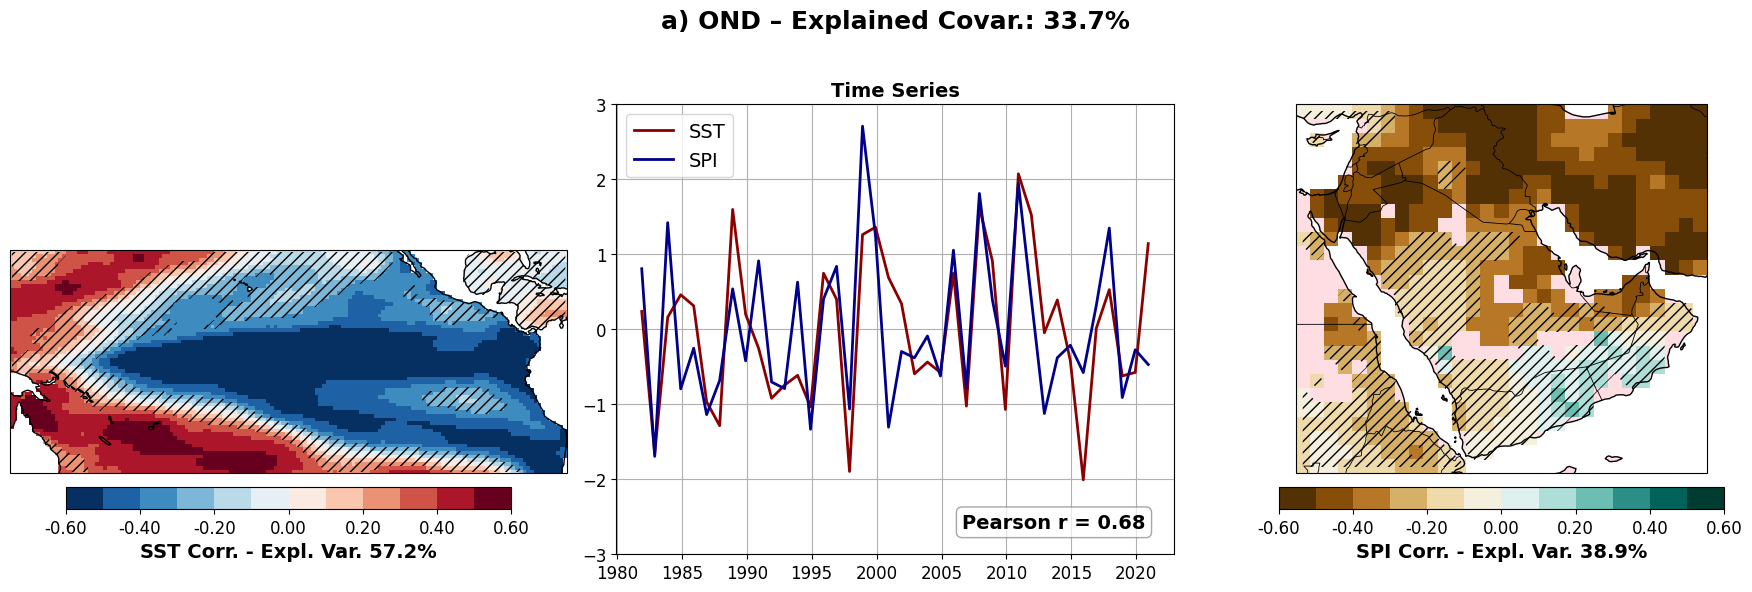

Processing season: NDJ 


c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


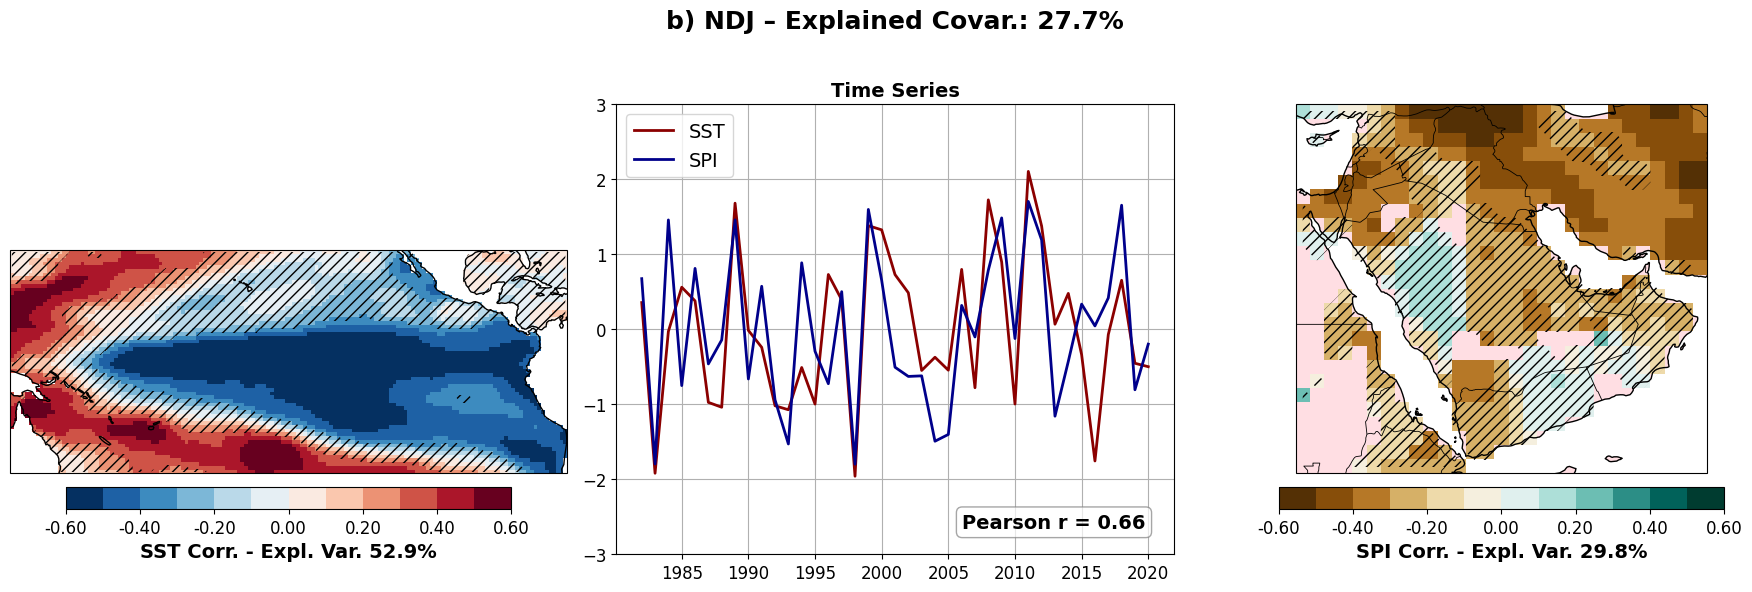

Processing season: DJF 


c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


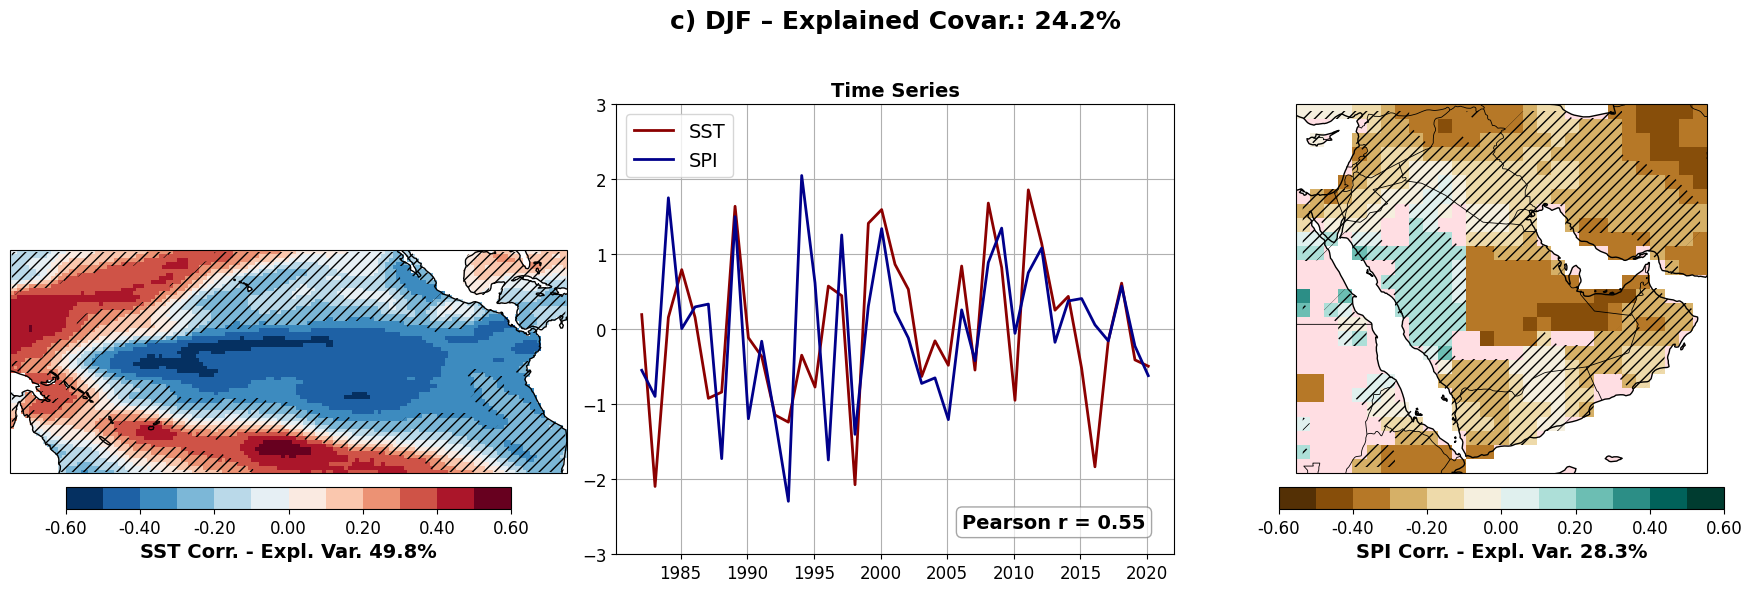

Processing season: JFM 


c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


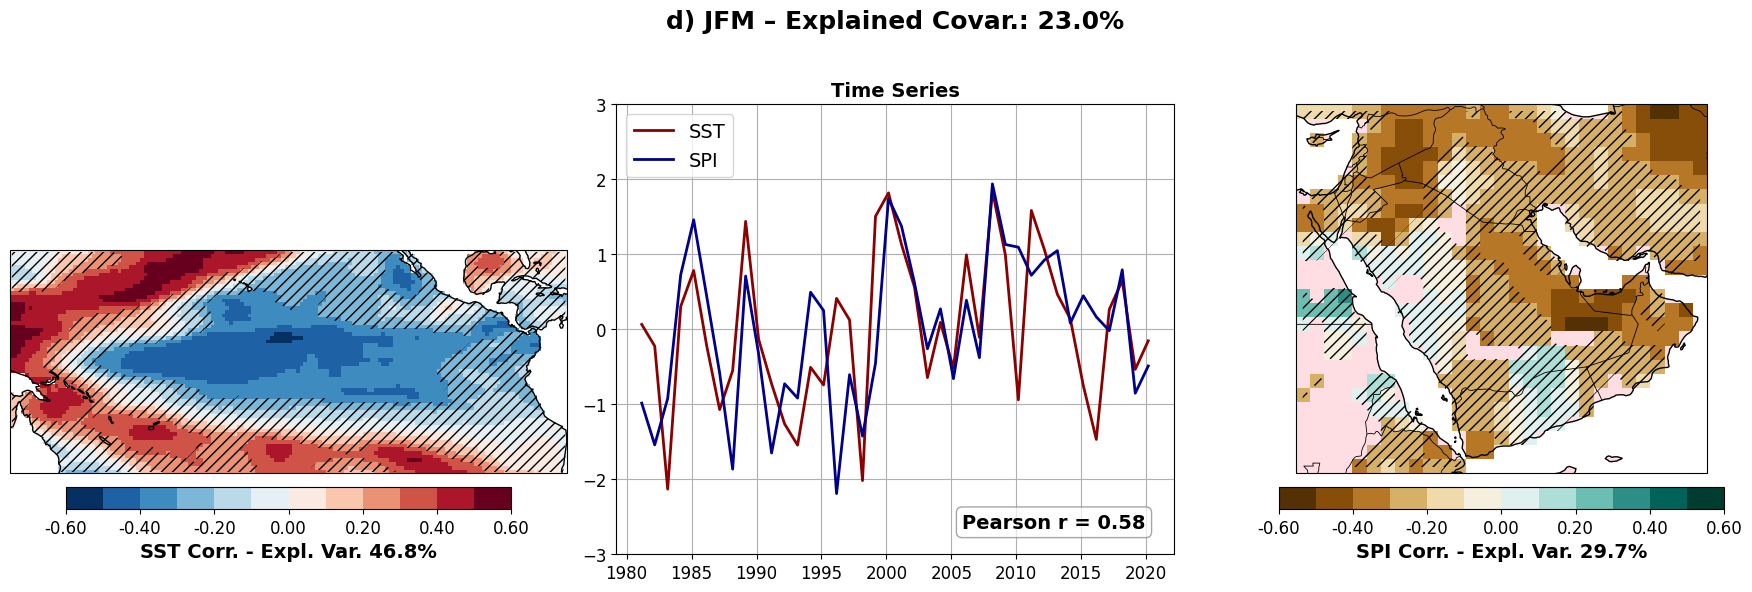

Processing season: FMA 


c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


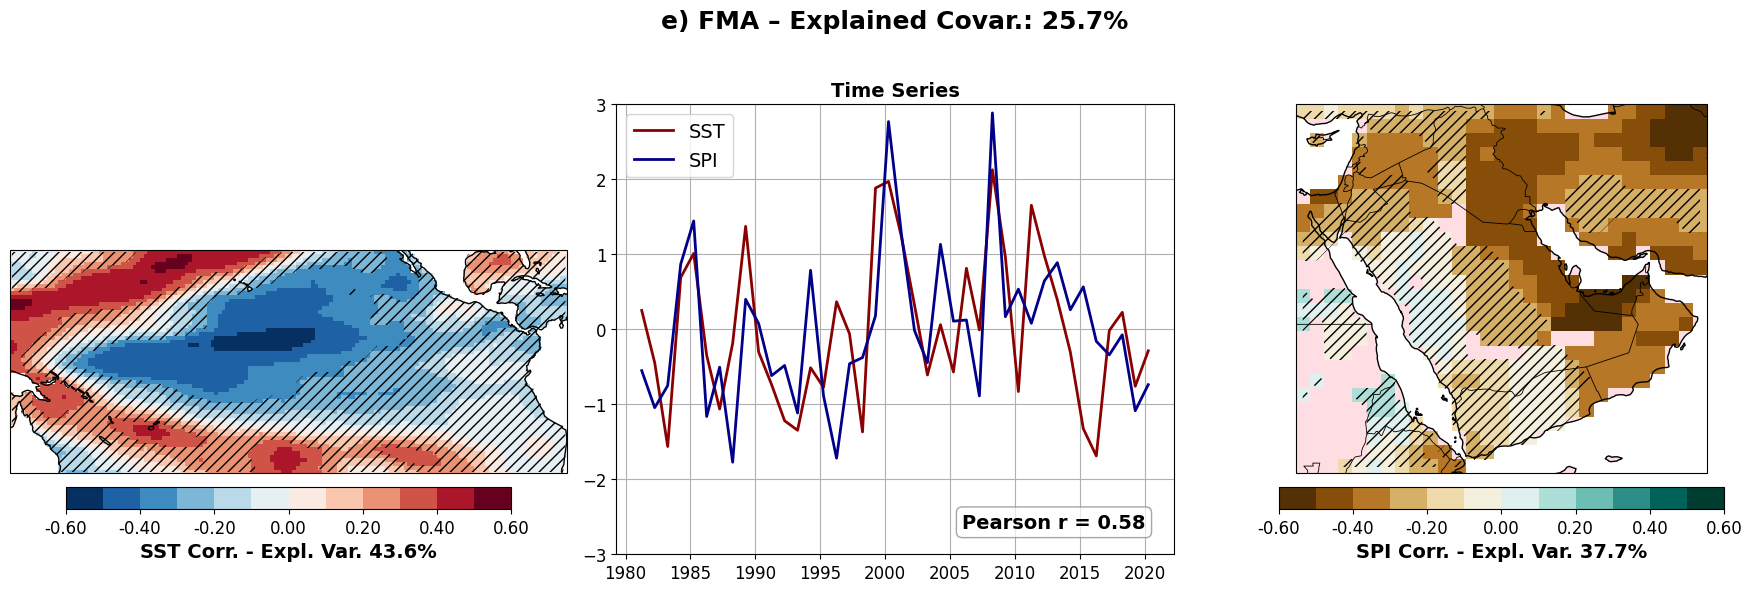

Processing season: MAM 


c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


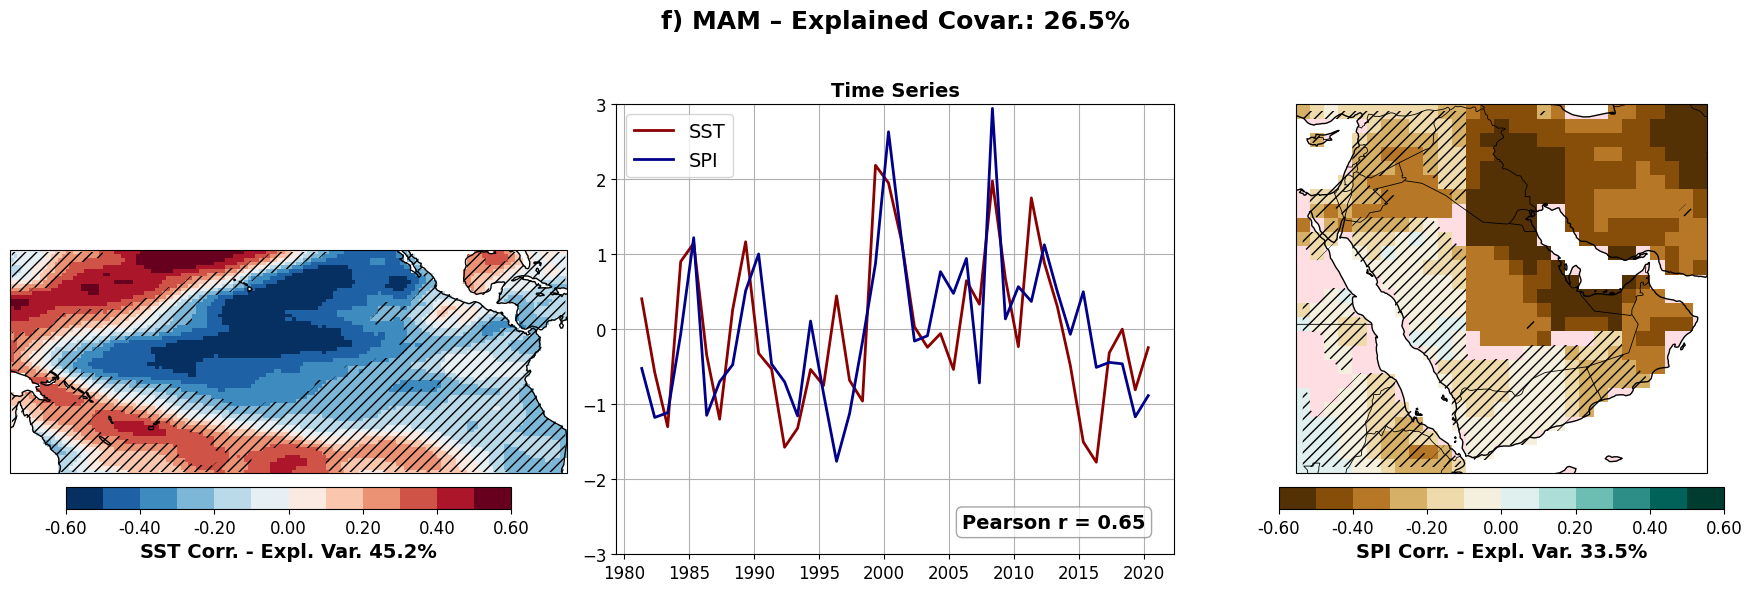

In [10]:
seasons = ['OND', 'NDJ', 'DJF', 'JFM', 'FMA', 'MAM']
labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']


for season, label in zip(seasons, labels):
    print(f"Processing season: {season} ")
    svd_analysis(sst.sst3m, spi, left_var='SST',n_modes=1, month=season, label=label)
    #print(f"Processing season: {season} with detrending")
    #svd_analysis(sst.sst3m,spi, left_var='SST', n_modes=3, month=season, label=label,detrend=True)

# ERA5


In [26]:
ds = xr.open_dataset('../data/spi3_era5.nc')
spi = ds.rename_vars({list(ds.data_vars)[0]: 'spi'}).sortby('T').spi

spi = spi.rename({'X': 'lon','Y':'lat', 'T':'time'})

spi = spi.sel(time=slice('1981-01-01', '2020-12-31'))

mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(
    spi['lon'], spi['lat']
)

In [27]:

#NOAA COBE SST data
sst = xr.open_dataset('../data/sst.mon.mean.nc').sortby('time').sel(time=slice('1900-01-01', '2024-12-31'))


sst['sst3m'] = sst['sst'] + sst['sst'].shift(time=1) + sst['sst'].shift(time=2)

#put lon is -180 to 180
#sst = sst.assign_coords(lon=(((sst.lon + 180) % 360) - 180)).sortby('lon')
#match time periods
sst = sst.sel(time=slice(spi['time'][0], spi['time'][-1]))
#lat=slice(60, -60), lon=slice(-180, 180))
#select enso region
sst = sst.sel(lat=slice(30, -30), lon=slice(140, 290))


In [28]:
def svd_analysis(left, right, n_modes=1, month=None, label=None, left_var="SST", right_var='SPI',land_mask=mask,
                 left_proj=ccrs.PlateCarree(central_longitude=150), right_proj = ccrs.PlateCarree(), detrend=False):


    if month is not None:
        months = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
        month_num = months.index(month) + 1
        left = left.sel(time=left['time.month'] == month_num)
        right = right.sel(time=right['time.month'] == month_num)
    right_mask = (right.isel(time=0).notnull().values) & (land_mask == 0)

    if right_var == 'SPI':
        right = right.where(right_mask)

    if detrend:
        def xr_detrend(da):
            return xr.apply_ufunc(
                scipy_detrend,
                da,
                input_core_dims=[['time']],
                output_core_dims=[['time']],
                vectorize=True,
                dask='parallelized',
                output_dtypes=[da.dtype]
            )
        left = xr_detrend(left.fillna(0)).transpose('time','lat','lon')
        right = xr_detrend(right.fillna(0)).transpose('time','lat','lon')

    left = (left - left.mean(dim='time', skipna=True)) / (left.std(dim='time', skipna=True) + 1e-6)
    right = (right - right.mean(dim='time', skipna=True)) / (right.std(dim='time', skipna=True) + 1e-6)

    mca = xMCA(left.fillna(0), right.fillna(0))
    mca.apply_coslat()
    mca.solve()


    X = left.fillna(0)
    Y = right.fillna(0)



    if month is not None:
        mca.set_field_names(f'{left_var} ({month})', f'{right_var} ({month})')
    else:
        mca.set_field_names({left_var}, {right_var})

    # --- ADDED: helper to compute Pearson r and p-value per gridcell
    from scipy.stats import pearsonr
    def correlate_grid_with_pval(grid_data, pc):
        """
        grid_data: DataArray (time, lat, lon)
        pc: DataArray (time,) aligned in time with grid_data
        Returns (corr_da, pval_da) as DataArray (lat, lon)
        """
        lats = grid_data['lat'].values
        lons = grid_data['lon'].values
        corr = np.full((len(lats), len(lons)), np.nan)
        pval = np.full((len(lats), len(lons)), np.nan)

        pc_vals = pc.values
        for i in range(len(lats)):
            for j in range(len(lons)):
                ts_da = grid_data.isel(lat=i, lon=j)
                ts = ts_da.values

                if ts.shape[0] != pc_vals.shape[0]:
                    try:
                        ts = ts_da.sel(time=pc['time']).values
                    except Exception:
                        continue

                mask = np.isfinite(ts) & np.isfinite(pc_vals)
                if np.sum(mask) < 3:
                    continue

                ts_masked = ts[mask]
                pc_masked = pc_vals[mask]

                # Skip if constant (all same value)
                if np.all(ts_masked == ts_masked[0]) or np.all(pc_masked == pc_masked[0]):
                    continue

                try:
                    r, p = pearsonr(pc_masked, ts_masked)
                except Exception:
                    r, p = np.nan, np.nan

                corr[i, j] = r
                pval[i, j] = p

        corr_da = xr.DataArray(corr, coords=[lats, lons], dims=['lat', 'lon'])
        pval_da = xr.DataArray(pval, coords=[lats, lons], dims=['lat', 'lon'])
        return corr_da, pval_da
    # --- END ADDED


    table = []
    for i in range(n_modes):
        fig = plt.figure(figsize=(18, 6))

                # Rank-1 reconstructions
        X_recon = mca.reconstructed_fields(mode=slice(i+1,i+2))['left']
        Y_recon = mca.reconstructed_fields(mode=slice(i+1,i+2))['right']

        # Total and explained variance
        total_var_X = np.sum(np.var(X, axis=0, ddof=1))
        total_var_Y = np.sum(np.var(Y, axis=0, ddof=1))
        explained_var_X = np.sum(np.var(X_recon, axis=0, ddof=1))
        explained_var_Y = np.sum(np.var(Y_recon, axis=0, ddof=1))

        frac_var_left = explained_var_X / total_var_X
        frac_var_right = explained_var_Y / total_var_Y


        left_map = mca.eofs()['left'].sel(mode=i+1)
        right_map = mca.eofs()['right'].sel(mode=i+1)
        right_map = right_map.where(right_mask)

        left_pcs = mca.pcs()['left'].sel(mode=i+1)
        right_pcs = mca.pcs()['right'].sel(mode=i+1)
        left_pcs = (left_pcs - left_pcs.mean()) / left_pcs.std()
        right_pcs = (right_pcs - right_pcs.mean()) / right_pcs.std()
        r_val = np.corrcoef(left_pcs.values, right_pcs.values)[0, 1]

                # Use PCs
        left_pcs = mca.pcs()['left'].sel(mode=i+1)
        right_pcs = mca.pcs()['right'].sel(mode=i+1)

        # Normalize PCs
        left_pcs = (left_pcs - left_pcs.mean()) / left_pcs.std()
        right_pcs = (right_pcs - right_pcs.mean()) / right_pcs.std()

        # Align time for correlation
        left = left.sel(time=left_pcs['time'])
        right = right.sel(time=right_pcs['time'])

        # Grid-wise correlation between PC and gridcell time series
        # --- REPLACED: compute correlation AND p-values with helper above
        left_map, left_pval = correlate_grid_with_pval(left, right_pcs)
        right_map, right_pval = correlate_grid_with_pval(right, left_pcs)
        # --- END REPLACEMENT

        # Mask invalid areas
        right_map = right_map.where(right_mask)
        left_map = left_map.where(~np.isnan(left.isel(time=0)))
        right_map = right_map.where(~np.isnan(right.isel(time=0)))

        explained_covar = mca.explained_variance()[i] / 100

        nino_lat_bounds = (5, -5)     # Latitude bounds
        nino_lon_bounds = (170, 240)  # Longitude bounds in 0-360



        # Subset and compute average anomaly over Nino3.4 region
        nino34_anom = left_map.sel(
        lon=slice(nino_lon_bounds[0], nino_lon_bounds[1]),
        lat=slice(nino_lat_bounds[0], nino_lat_bounds[1]))
        


        # Take the mean over time (or specific month if already selected)
        mean_nino34 = nino34_anom.mean()

        # Conditionally flip the sign based on Nino3.4 anomaly
        if mean_nino34 > 0 and left_var == 'SST':
            left_map = -left_map
            right_map = -right_map
            left_pcs = -left_pcs
            right_pcs = -right_pcs
        
        # NAO bounds western africa
        nao_lat_bounds = (20, 0)
        nao_lon_bounds = (-20, 20) 

        # Subset and compute average anomaly over NAO region
        nao_anom = left_map.sel(
        lon=slice(nao_lon_bounds[0], nao_lon_bounds[1]),
        lat=slice(nao_lat_bounds[0], nao_lat_bounds[1]))

        # Take the mean over time (or specific month if already selected)
        mean_nao = nao_anom.mean()

        # Conditionally flip the sign based on NAO anomaly
        if mean_nao <0 and left_var == 'SLP':
             left_map = -left_map
             right_map = -right_map
             left_pcs = -left_pcs
             right_pcs = -right_pcs

        #print table with explaine covariance and explaine variance and pc time series correlation

        #print(f"Mode {i+1}:")
        #print(f"Explained Variance {left_var}: {frac_var_left:.2%}")
        #print(f"Explained Variance {right_var}: {frac_var_right:.2%}")
        #print(f"Pearson r between PCs: {r_val:.2f}\n")
        #print(f"Explained Covariance: {explained_covar:.1%}\n")

        #save these values in a table

        table.append([i+1, np.round(100*frac_var_left.values,1), np.round(100*frac_var_right.values,1),
                       np.round(r_val,2), np.round(explained_covar.values*100,1)])

        cbar_ticks = [-0.6,-0.5,-0.4, -0.3,-0.2,-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

        cmap_discrete = plt.get_cmap('RdBu_r', len(cbar_ticks)-1)

        #apply nan mask to left_map and right_map
        left_map = left_map.where(~np.isnan(left.isel(time=0)).values)
        right_map = right_map.where(right_mask)



        ax1 = fig.add_subplot(1, 3, 1, projection=left_proj)
        pcm1 = ax1.pcolormesh(
            left_map['lon'], left_map['lat'], left_map,
            transform=ccrs.PlateCarree(), cmap=cmap_discrete, 
            vmin=-0.6, vmax=0.6
        )
        ax1.coastlines()
        cbar1 = plt.colorbar(pcm1, ax=ax1, orientation='horizontal', pad=0.03, shrink=0.8,
                            format=mticker.FormatStrFormatter('%.1f'))
        cbar1.set_label(f"{left_var} Corr. - Expl. Var. {frac_var_left:.1%}", fontsize=14, fontweight='bold')
        cbar1.ax.tick_params(labelsize=12)
        cbar1.ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
        ax1.tick_params(labelsize=12)

        # --- ADDED: hatch non-significant regions on left map (p > 0.05)
        alpha = 0.05
        try:
            sig_mask_left = (left_pval > alpha).astype(int)
            cs1 = ax1.contourf(
                left_map['lon'], left_map['lat'], sig_mask_left,
                levels=[0.5, 1.5], hatches=['///', None], colors='none',
                transform=ccrs.PlateCarree()
            )

            # Loop through contourf's collections to customize hatching
            for coll in cs1.collections:
                coll.set_edgecolor("black")   # hatch color
                coll.set_linewidth(0.8)     # hatch thickness
        except Exception:
            pass


        ax2 = fig.add_subplot(1, 3, 2)

        ax2.plot(left_pcs['time'], left_pcs, label=left_var, color='darkred', linewidth=2)
        ax2.plot(right_pcs['time'], right_pcs, label=right_var, color='darkblue', linewidth=2)
        ax2.set_title("Time Series", fontsize=14, fontweight='bold')
        ax2.legend(fontsize=14, loc='upper left')
        ax2.tick_params(labelsize=12)
        ax2.grid(True)
        ax2.set_ylim(-3, 3)

        ax2.text(0.95, 0.05, f"Pearson r = {r_val:.2f}",
                transform=ax2.transAxes,
                horizontalalignment='right',
                verticalalignment='bottom',
                fontsize=14,
                fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round'))

        
        cmap_discrete_right = plt.get_cmap('BrBG', len(cbar_ticks)-1)


        ax3 = fig.add_subplot(1, 3, 3, projection=right_proj)
        pcm2 = ax3.pcolormesh(
            right_map['lon'], right_map['lat'], right_map,
            transform=ccrs.PlateCarree(), cmap=cmap_discrete_right,
            vmin=-0.6, vmax=0.6
        )
        ax3.coastlines()
        ax3.add_feature(cfeature.BORDERS, linewidth=0.6)
        ax3.add_feature(cfeature.LAND, facecolor="lightpink", alpha=0.45)

        cbar2 = plt.colorbar(pcm2, ax=ax3, orientation='horizontal', pad=0.03, shrink=0.8,
                            format=mticker.FormatStrFormatter('%.1f'))
        cbar2.set_label(f"{right_var} Corr. - Expl. Var. {frac_var_right:.1%}", fontsize=14, fontweight='bold')
        cbar2.ax.tick_params(labelsize=12)
        cbar2.ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
        ax3.tick_params(labelsize=12)

        # --- ADDED: hatch non-significant regions on right map (p > 0.05)
        try:
            sig_mask_right = (right_pval > alpha).astype(int)
            cs3 = ax3.contourf(
                right_map['lon'], right_map['lat'], sig_mask_right,
                levels=[0.5, 1.5], hatches=['///', None], colors='none',
                transform=ccrs.PlateCarree()
            )

            # Loop through contourf's collections to customize hatching
            for coll in cs3.collections:
                #coll.set_edgecolor("black")   # hatch color
                coll.set_linewidth(1.5)     # hatch thickness
        except Exception:
            pass
        # --- END ADDED

        
        title = f"{label} {month} – Explained Covar.: {explained_covar:.1%}"
        plt.suptitle(title, fontsize=18, fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        if detrend:
            plt.savefig(f'figures/era5/svd_detrended_{left_var}_{right_var}_{month}_mode{i+1}.pdf', dpi=150)
        else:
            plt.savefig(f'figures/era5/svd_{left_var}_{right_var}_{month}_mode{i+1}.pdf', dpi=150)

        #merge pcs in one dataframe
        pcs_df = pd.concat([left_pcs.to_dataframe(), right_pcs.to_dataframe()], axis=1)

        #save pc time series to csv
        if detrend:

            pcs_df.to_csv(f'tables/era5/svd_detrended_{left_var}_{right_var}_{month}_mode{i+1}_PC.csv', index=True)
        else:
            pcs_df.to_csv(f'tables/era5/svd_{left_var}_{right_var}_{month}_mode{i+1}_PC.csv', index=True)



        # Show only for mode 1
        if i == 0:
            plt.show()

        # Always close to free memory
        plt.close()
                
                
    df = pd.DataFrame(
            table,
            columns=["Mode", f"Explained Var {left_var}", f"Explained Var {right_var}", "Pearson r", "Explained Cov"]
            )
            #save table as csv
    if detrend:
        df.to_csv(f'tables/era5/svd_detrended_{left_var}_{right_var}_{month}_table.csv', index=False)
    else:
        df.to_csv(f'tables/era5/svd_{left_var}_{right_var}_{month}_table.csv', index=False)


Processing season: OND 


c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


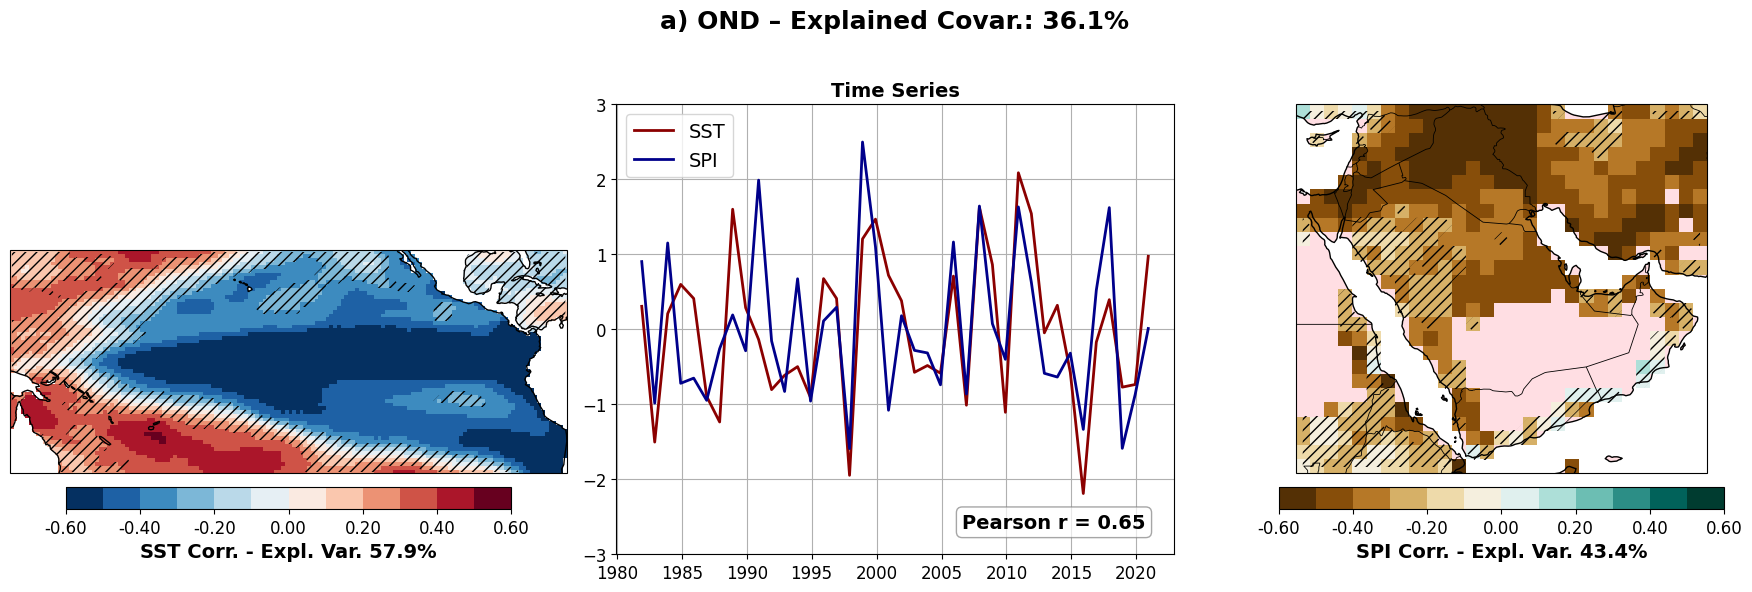

Processing season: NDJ 


c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


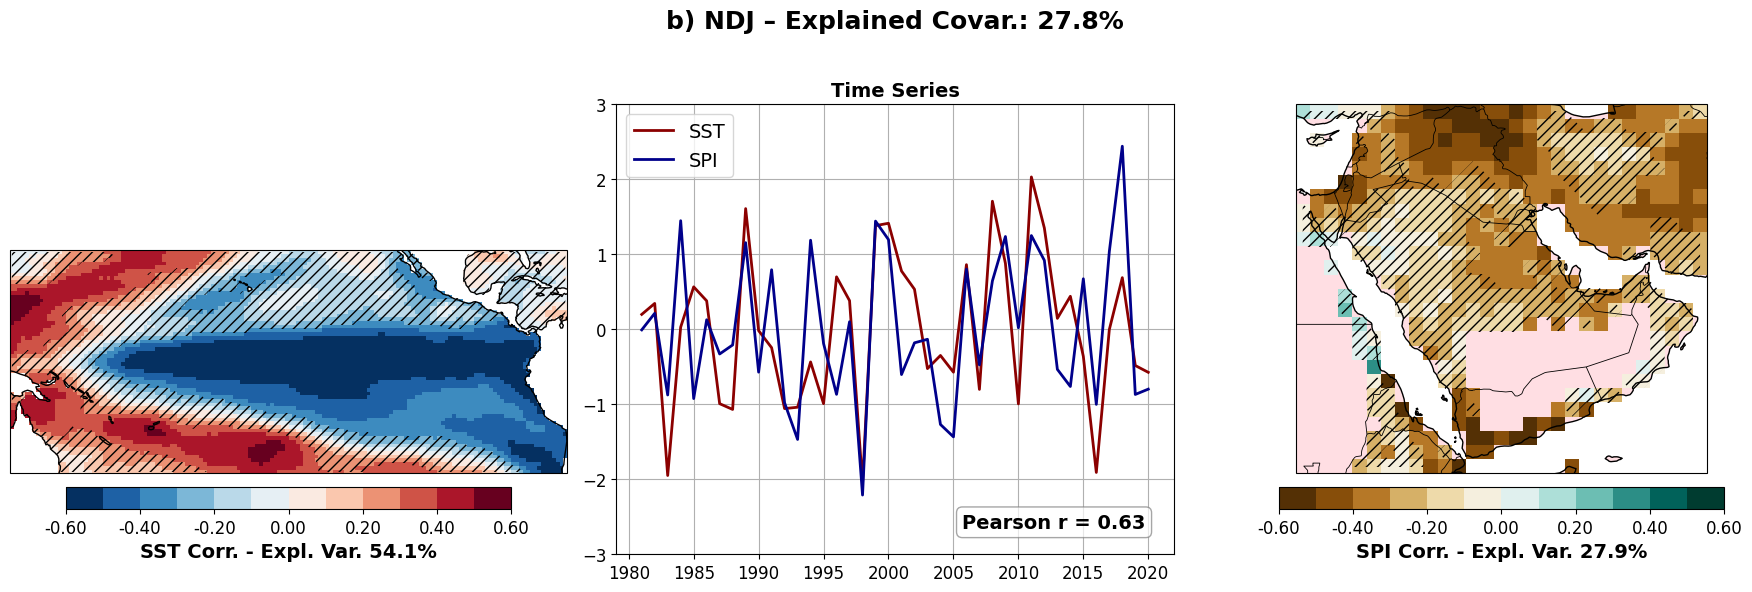

Processing season: DJF 


c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


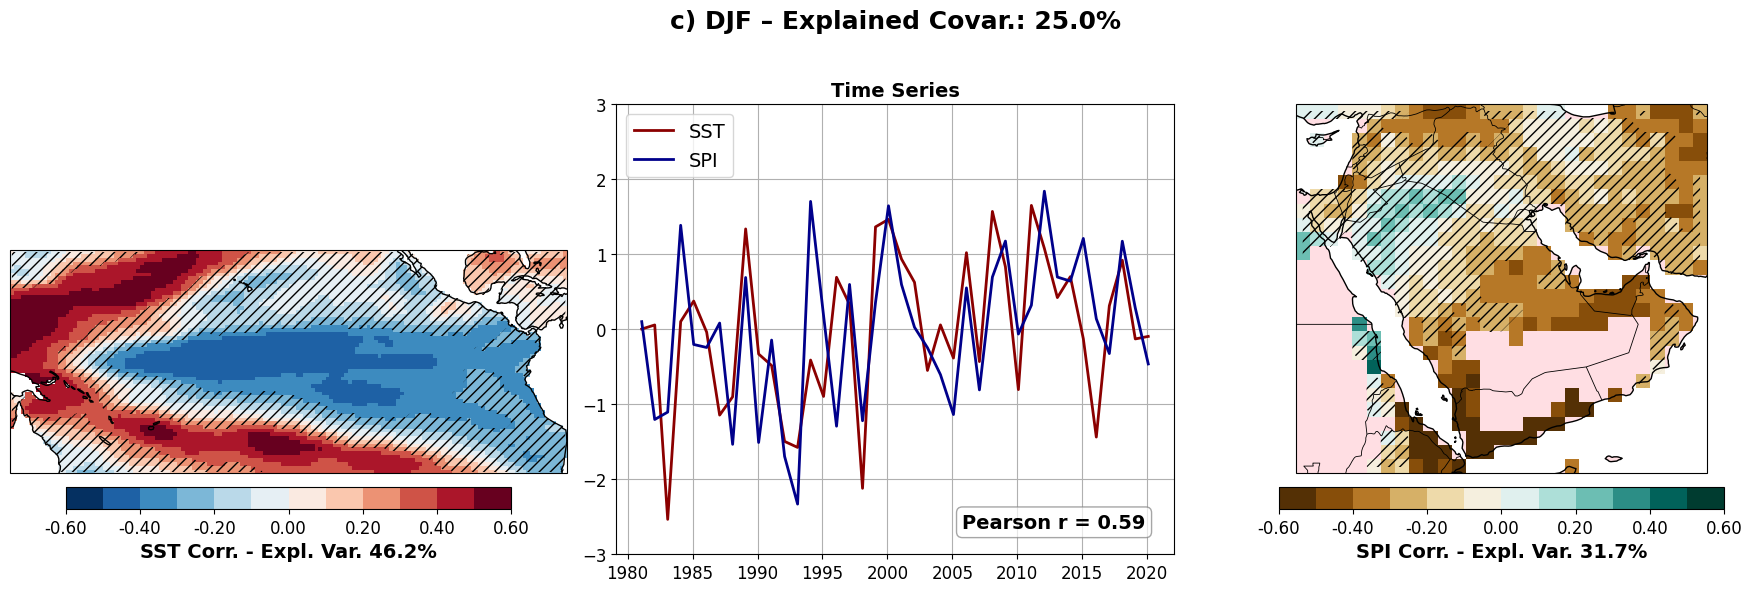

Processing season: JFM 


c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


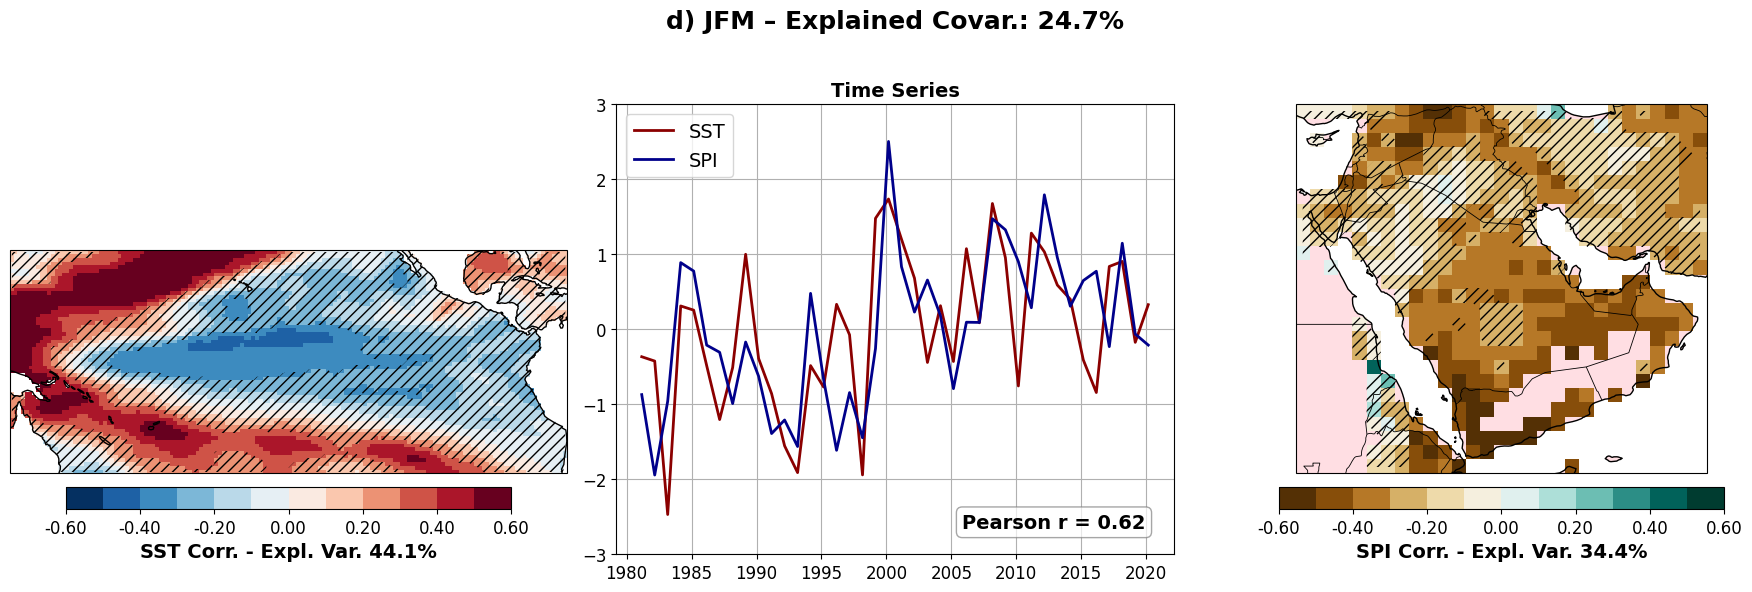

Processing season: FMA 


c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


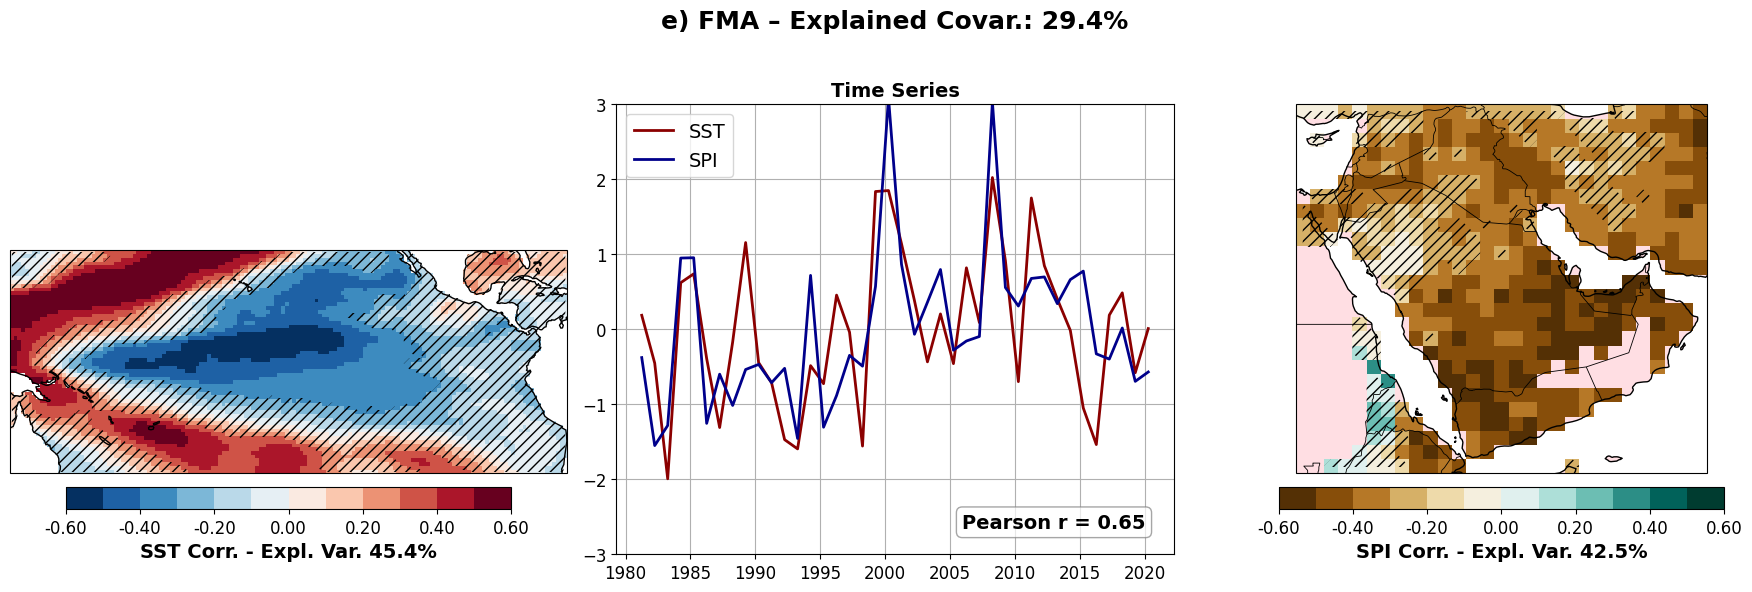

Processing season: MAM 


c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\emile\anaconda3\envs\ap-drought\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


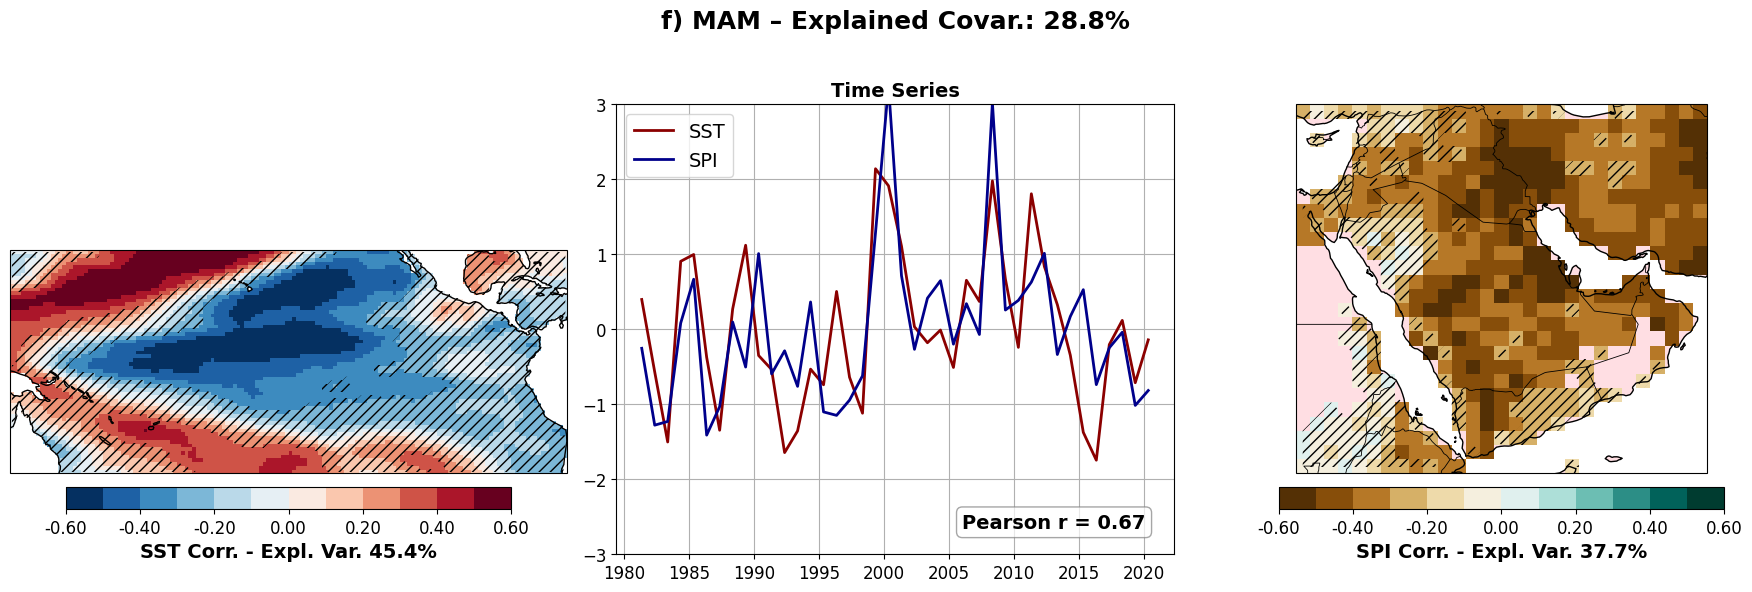

In [29]:
seasons = ['OND', 'NDJ', 'DJF', 'JFM', 'FMA', 'MAM']
labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']


for season, label in zip(seasons, labels):
    print(f"Processing season: {season} ")
    svd_analysis(sst.sst3m, spi, left_var='SST',n_modes=1, month=season, label=label)
    #print(f"Processing season: {season} with detrending")
    #svd_analysis(sst.sst3m,spi, left_var='SST', n_modes=3, month=season, label=label,detrend=True)